# Displacement

zid elastic displacement masln la 2 veloc 160 w 270 (focus 2) samiyon elastic disp.
nfs shi acceleration (7oton 3a nfs rasme positive w negative) samiyon acce + w -
perm settelement fi 3 souwar 160 w 270 w we7de fiya combination. (real lon wahad, predicted mtl ma hiye)

bade zid l unit, 7oton b millimeter msh meter (kel shi 3al x)
acceleration meter/sec-square

zid flowchar (draw.io ) taba3 l process.

[160. 210. 270. 320. 360. 380.]
[0. 1.]
{'df_160_0':       id  velocity       Period  Cycle_Number  experiment_number  position  \
0      0     160.0    300.65650       1772.25                4.5       0.0   
1      1     160.0    601.11325       3009.75                4.5       0.0   
2      2     160.0    901.65225       4246.75                4.5       0.0   
3      3     160.0   1202.14075       5483.50                4.5       0.0   
4      4     160.0   1502.75775       6721.00                4.5       0.0   
..   ...       ...          ...           ...                ...       ...   
156  156     160.0  47182.42950     194768.75                4.5       0.0   
157  157     160.0  47482.93375     196004.00                4.5       0.0   
158  158     160.0  47783.59375     197242.75                4.5       0.0   
159  159     160.0  48084.02750     198479.50                4.5       0.0   
160  160     160.0  48384.71475     199717.25                4.5       0.0   

     displ

C:\Users\alira\AppData\Local\Temp\ipykernel_19020\2243709217.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoothed_displacement'] = df['displacement'].rolling(window=window_size, center=True).mean()
C:\Users\alira\AppData\Local\Temp\ipykernel_19020\2243709217.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame

Best Model Parameters: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Validation Score (cross-validated): 1.0000
Test Score: 1.0000
R2 Score on Validation Set: 0.9996
R2 Score on Test Set: 0.9959


C:\Users\alira\AppData\Local\Temp\ipykernel_19020\2243709217.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['displacement_mm'] = ground_truth_filtered['displacement'] * 1000


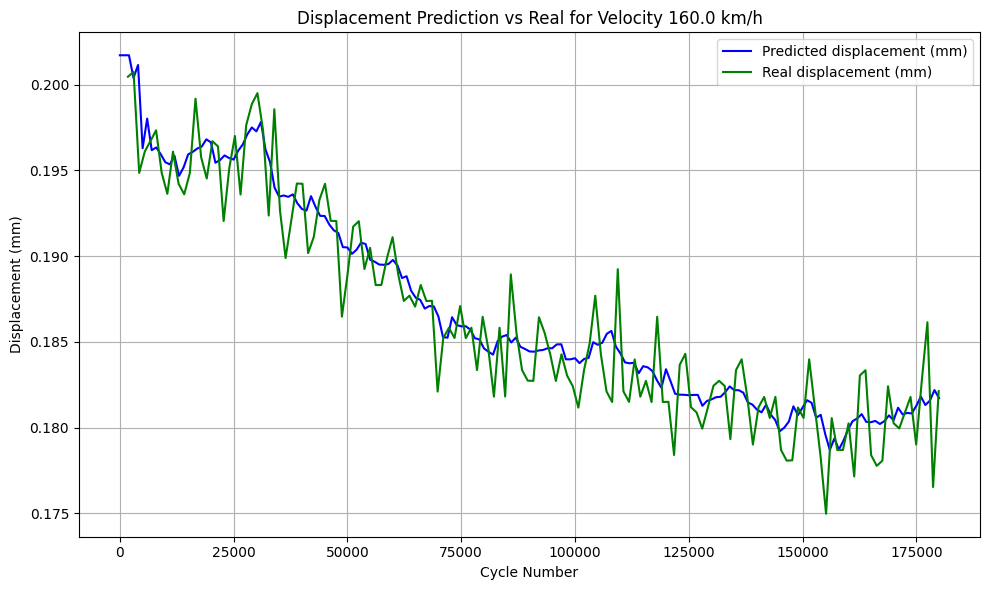

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np



df = pd.read_csv('../data/dataset/final_experiment_avg_df.csv')


def create_tables_by_velocity_position(df):
    tables = {}
    unique_velocities = df['velocity'].unique()
    unique_positions = df['position'].unique()

    print(unique_velocities)
    print(unique_positions)

    for velocity in unique_velocities:
        for position in unique_positions:
            filtered_df = df[(df['velocity'] == int(velocity)) & (df['position'] == int(position))]
            table_name = f"df_{int(velocity)}_{int(position)}"
            tables[table_name] = filtered_df
    
    return tables

tables_dict = create_tables_by_velocity_position(df)
print(tables_dict)
def calculate_smoothed_displacement(df, window_size=5):
    df['smoothed_displacement'] = df['displacement'].rolling(window=window_size, center=True).mean()

    if len(df) > 1:
        first_value = df['displacement'].iloc[0]
        connect_value = df['smoothed_displacement'].iloc[window_size]
        linear_interp_start = np.linspace(first_value, connect_value, num=window_size)
        df['smoothed_displacement'].iloc[:window_size] = linear_interp_start

        last_value = df['displacement'].iloc[-1]
        connect_value_end = df['smoothed_displacement'].iloc[-(window_size + 1)]
        linear_interp_end = np.linspace(connect_value_end, last_value, num=window_size)
        df['smoothed_displacement'].iloc[-window_size:] = linear_interp_end
    return df

for table_name, table_df in tables_dict.items():
    tables_dict[table_name] = calculate_smoothed_displacement(table_df, 5)

combined_df = pd.concat(tables_dict.values(), ignore_index=True)

combined_df = combined_df.sort_values(by='id').reset_index(drop=True)

average_df = (
    combined_df.groupby(['velocity', 'Cycle_Number'])
    .agg({
        'Period': 'mean',
        'experiment_number': 'mean',
        'position': 'mean',
        'displacement': 'mean',
        'smoothed_displacement': 'mean'
    })
    .reset_index()
)

X = average_df[['velocity', 'Cycle_Number']]
y = average_df['smoothed_displacement']


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


def custom_scorer(y_true, y_pred):
    score = 1 - mean_absolute_error(y_true, y_pred)
    return score


model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'max_features': ['auto', 'sqrt']
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=make_scorer(custom_scorer),
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train, y_train)
smoothed_displacement_rf_model = grid_search.best_estimator_


val_scores = cross_val_score(smoothed_displacement_rf_model, X_val, y_val, cv=5, scoring=make_scorer(custom_scorer))
mean_val_score = np.mean(val_scores)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Validation Score (cross-validated): {mean_val_score:.4f}")


smoothed_displacement_rf_model.fit(X_train_val, y_train_val) 
y_test_pred = smoothed_displacement_rf_model.predict(X_test)
test_score = custom_scorer(y_test, y_test_pred)

print(f"Test Score: {test_score:.4f}")


from sklearn.metrics import r2_score

y_pred_val = smoothed_displacement_rf_model.predict(X_val)
r2_val = r2_score(y_val, y_pred_val)

y_pred_test = smoothed_displacement_rf_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'R2 Score on Validation Set: {r2_val:.4f}')
print(f'R2 Score on Test Set: {r2_test:.4f}')

def generate_and_plot_displacement(model, ground_truth_df, start_cycle, end_cycle, step_size, velocity):
    cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
    new_data = pd.DataFrame({
        'velocity': [velocity] * len(cycle_numbers),
        'Cycle_Number': cycle_numbers
    })

    # Predict displacement (convert to millimeters)
    predicted_settlement = model.predict(new_data) * 1000

    # Filter ground truth data for the specified cycle range and velocity
    ground_truth_filtered = ground_truth_df[
        (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) & 
        (ground_truth_df['velocity'] == velocity)
    ]

    # Convert real displacement to millimeters
    ground_truth_filtered['displacement_mm'] = ground_truth_filtered['displacement'] * 1000

    plt.figure(figsize=(10, 6))
    plt.plot(cycle_numbers, predicted_settlement, label='Predicted displacement (cm)', color='blue', marker='')

    plt.plot(ground_truth_filtered['Cycle_Number'], ground_truth_filtered['displacement_mm'], 
             label='Real displacement (cm)', color='green', marker='')

    plt.xlabel('Cycle Number')
    plt.ylabel('Displacement (cm)')
    plt.title(f'Displacement Prediction vs Real for Velocity {velocity} km/h')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
generate_and_plot_displacement(smoothed_displacement_rf_model, average_df,
                               start_cycle=0, end_cycle=180000, step_size=1000,
                               velocity=160.0)


In [2]:
import pickle

# Save the model to a file
with open('../../app/models/v1/smoothed_displacement_rf_model.pkl', 'wb') as file:
    pickle.dump(smoothed_displacement_rf_model, file)

print("Model saved successfully as smoothed_displacement_rf_model.pkl")

Model saved successfully as smoothed_displacement_rf_model.pkl


In [3]:
combined_df

,id,velocity,Period,Cycle_Number,experiment_number,position,displacement,smoothed_displacement
0,0,160.0,300.65650,1772.25,4.5,0.0,0.000203,0.000203
1,1,160.0,601.11325,3009.75,4.5,0.0,0.000196,0.000200
2,2,160.0,901.65225,4246.75,4.5,0.0,0.000193,0.000198
3,3,160.0,1202.14075,5483.50,4.5,0.0,0.000195,0.000196
4,4,160.0,1502.75775,6721.00,4.5,0.0,0.000193,0.000194
...,...,...,...,...,...,...,...,...
1191,1191,380.0,19230.41400,188809.50,6.5,1.0,0.000232,0.000239
1192,1192,380.0,19530.91400,191746.00,6.5,1.0,0.000242,0.000239
1193,1193,380.0,19831.52350,194684.50,6.5,1.0,0.000237,0.000239
1194,1194,380.0,20132.34350,197626.00,6.5,1.0,0.000238,0.000239


C:\Users\alira\AppData\Local\Temp\ipykernel_19020\2243709217.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['displacement_mm'] = ground_truth_filtered['displacement'] * 1000


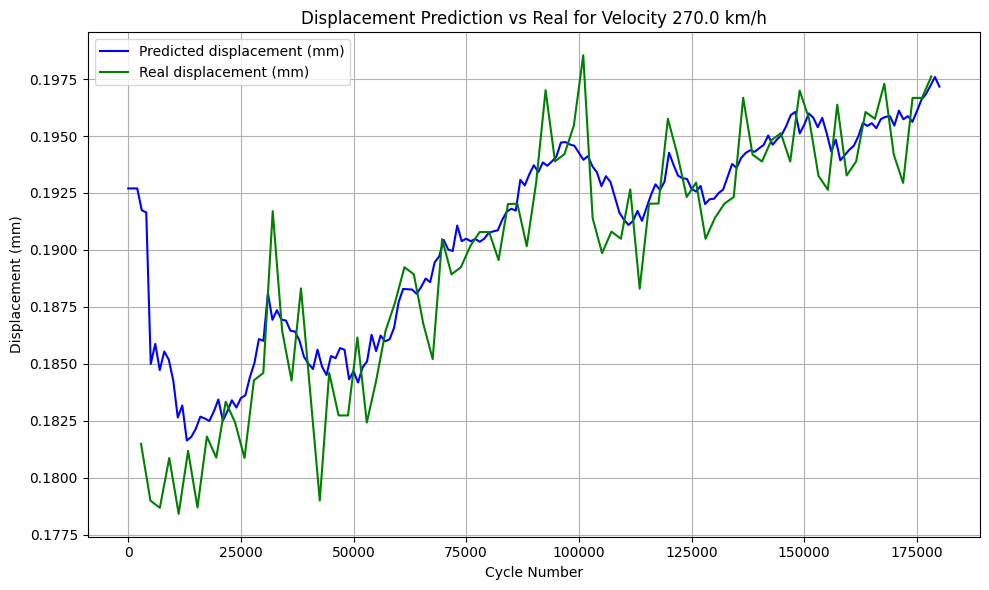

In [4]:
generate_and_plot_displacement(smoothed_displacement_rf_model, average_df,
                             start_cycle=0, end_cycle=180000, step_size=1000,
                             velocity=270.0)

C:\Users\alira\AppData\Local\Temp\ipykernel_19020\333349726.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['smoothed_displacement_mm'] = ground_truth_filtered['smoothed_displacement'] * 1000
C:\Users\alira\AppData\Local\Temp\ipykernel_19020\333349726.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['smoothed_displacement_mm'] = ground_truth_filtered['smoothed_displacement'] * 1000
C:\Users\alira\AppData\Local\Temp\ipykernel_19020\333349726.py:53: Setting

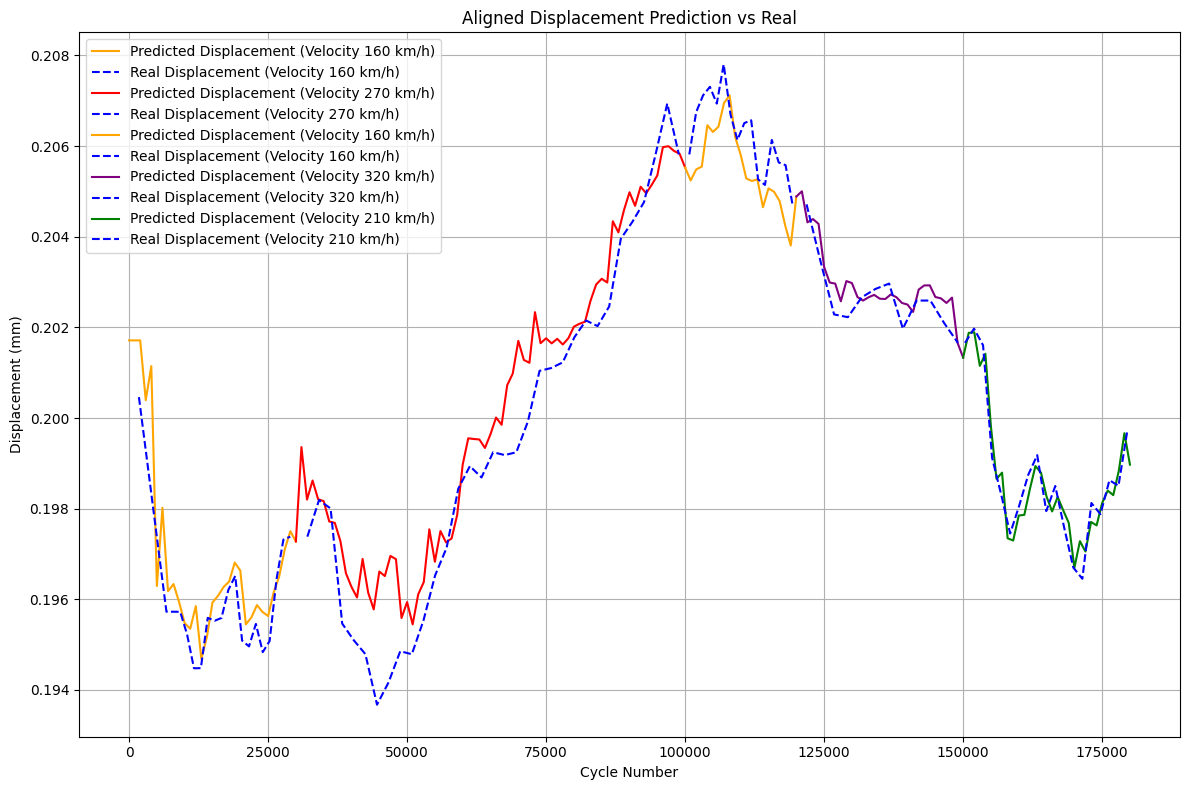

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def generate_and_plot_displacement_multi_aligned(model, ground_truth_df, velocity_ranges, step_size):
    """
    Generates and plots displacement predictions for multiple velocity ranges, ensuring proper alignment.
    
    Parameters:
        model: Trained machine learning model for prediction.
        ground_truth_df: DataFrame containing the ground truth data.
        velocity_ranges: List of lists, where each sublist contains [velocity, start_cycle, end_cycle].
        step_size: Step size for generating cycles.
    """
    all_cycle_numbers = []
    all_predictions = []
    previous_end_value = None  # To align subsequent predictions
    previous_gt_value = None  # To align subsequent ground truth values

    # Define a color map for velocities
    color_map = {velocity: color for velocity, color in zip(
        sorted(set([v[0] for v in velocity_ranges])),
        ['orange', 'green', 'red', 'purple', 'cyan', 'magenta']
    )}

    plt.figure(figsize=(12, 8))

    for i, (velocity, start_cycle, end_cycle) in enumerate(velocity_ranges):
        # Generate cycle numbers for the current velocity range
        cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
        new_data = pd.DataFrame({
            'velocity': [velocity] * len(cycle_numbers),
            'Cycle_Number': cycle_numbers
        })
        ground_truth_filtered = ground_truth_df[
            (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
            (ground_truth_df['velocity'] == velocity)
        ]

        # Predict displacement for the current velocity and convert to millimeters
        predicted_displacement = model.predict(new_data) * 1000

        # Convert real displacement to millimeters
        ground_truth_filtered['smoothed_displacement_mm'] = ground_truth_filtered['smoothed_displacement'] * 1000

        # Adjust predictions for continuity based on the previous end value
        if previous_end_value is not None:
            adjustment = previous_end_value - predicted_displacement[0]
            predicted_displacement += adjustment

        # Adjust ground truth for continuity
        if previous_gt_value is not None:
            adjustment = previous_gt_value - ground_truth_filtered['smoothed_displacement_mm'].iloc[0]
            ground_truth_filtered['smoothed_displacement_mm'] += adjustment

        # Update the end value for the next velocity
        previous_end_value = predicted_displacement[-1]
        previous_gt_value = ground_truth_filtered['smoothed_displacement_mm'].iloc[-1]

        # Append cycle numbers and predictions for the current range
        all_cycle_numbers.extend(cycle_numbers)
        all_predictions.extend(predicted_displacement)

        # Plot predictions
        plt.plot(cycle_numbers, predicted_displacement, 
                 label=f'Predicted Displacement (Velocity {velocity} km/h)', 
                 color=color_map[velocity], marker='')

        # Plot ground truth data
        plt.plot(
            ground_truth_filtered['Cycle_Number'], 
            ground_truth_filtered['smoothed_displacement_mm'], 
            label=f'Real Displacement (Velocity {velocity} km/h)', 
            color='b', linestyle='dashed'
        )

    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Displacement (cm)')
    plt.title('Aligned Displacement Prediction vs Real')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example usage
velocity_ranges = [
    [160, 0, 30000],
    [270, 30000, 100000],
    [160, 100000, 120000],
    [320, 120000, 150000],
    [210, 150000, 180000]
]

generate_and_plot_displacement_multi_aligned(
    model=smoothed_displacement_rf_model,
    ground_truth_df=average_df,
    velocity_ranges=velocity_ranges,
    step_size=1000
)


# Permanent Settlement

C:\Users\alira\AppData\Local\Temp\ipykernel_19020\275305122.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['position'] = final_df['position'].replace({'Right': 0, 'Left': 1})
C:\Users\alira\AppData\Local\Temp\ipykernel_19020\275305122.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_2['id'] = range(len(table_2))
C:\Users\alira\AppData\Local\Temp\ipykernel_19020\275305122.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[160. 210. 270. 320. 360. 380. 400.]
[0.  1.  0.5]
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Model Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Validation Score (cross-validated): 1.0000
Test Score: 1.0000
R2 Score on Validation Set: 0.9993
R2 Score on Test Set: 0.9964


C:\Users\alira\AppData\Local\Temp\ipykernel_19020\275305122.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['Difference_mm'] = ground_truth_filtered['Difference'] * 1000


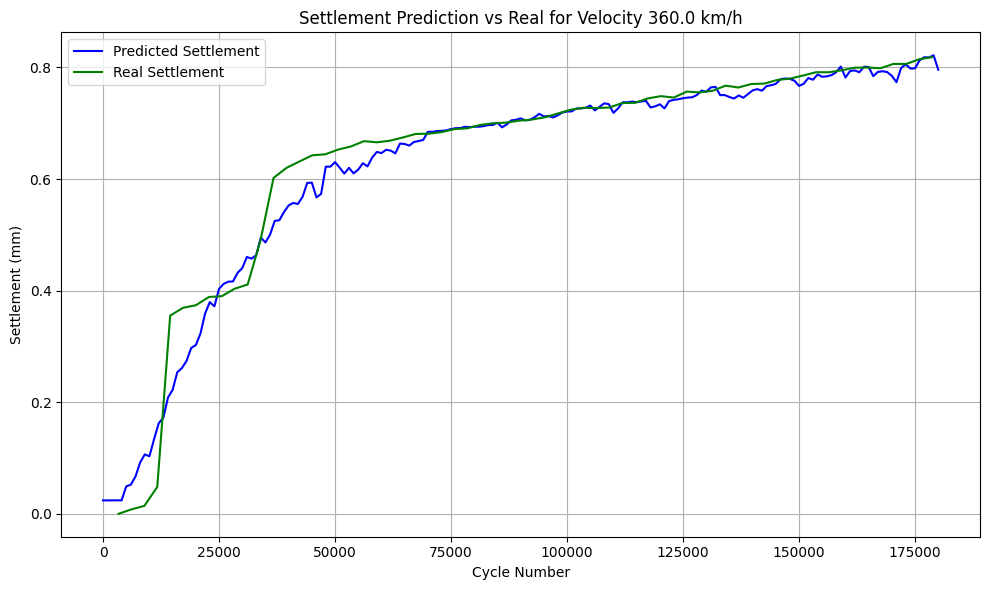

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import numpy as np

final_df = pd.read_csv('../data/dataset/combined_valeurs.csv')

def generate_and_plot_settlement(model, ground_truth_df, start_cycle, end_cycle, step_size, velocity):
    """
    Generates and plots settlement predictions and ground truth values.

    Parameters:
        model: Trained machine learning model for prediction.
        ground_truth_df: DataFrame containing the ground truth data.
        start_cycle: Starting cycle number for prediction.
        end_cycle: Ending cycle number for prediction.
        step_size: Step size for generating cycles.
        velocity: Velocity at which predictions are generated.
    """
    # Generate cycle numbers for the prediction
    cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
    new_data = pd.DataFrame({
        'velocity': [velocity] * len(cycle_numbers),
        'Cycle_Number': cycle_numbers
    })

    # Predict settlement and convert to millimeters
    predicted_settlement = model.predict(new_data) * 1000

    # Filter ground truth data for the specified cycle range and velocity
    ground_truth_filtered = ground_truth_df[
        (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
        (ground_truth_df['velocity'] == velocity)
    ]

    # Convert real settlement (Difference) to millimeters
    ground_truth_filtered['Difference_mm'] = ground_truth_filtered['Difference'] * 1000
    
    # Plot predicted settlement
    plt.figure(figsize=(10, 6))
    plt.plot(cycle_numbers, predicted_settlement, label='Predicted Settlement', color='blue', marker='')
    
    # Plot real settlement (ground truth)
    plt.plot(ground_truth_filtered['Cycle_Number'], ground_truth_filtered['Difference_mm'], 
             label='Real Settlement', color='green', marker='')
    
    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Settlement (cm)')
    plt.title(f'Settlement Prediction vs Real for Velocity {velocity} km/h')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()





def calculate_first_smoothed_displacement(df, window_size=5):
    df['smoothed_displacement'] = np.nan
    
    for index in df.index:
        data_to_smooth = pd.to_numeric(df.iloc[index, 19:139], errors='coerce')
        
        smoothed_data = data_to_smooth.rolling(window=window_size, center=True).mean()
        
        first_non_nan_value = smoothed_data[smoothed_data.notna()].iloc[0] if smoothed_data.notna().any() else np.nan
        
        df.at[index, 'smoothed_displacement'] = first_non_nan_value
    
    return df

final_df = calculate_first_smoothed_displacement(final_df)


def add_segmented_differences(df):
    """
    Calculates the difference between each row's 'smoothed_displacement' and the 
    first value within each segment where 'velocity' and 'position' are consistent.
    """
    df['Difference'] = 0.0
    
    reference_value = None
    current_velocity = None
    current_position = None

    for i in range(len(df)):
        row = df.iloc[i]
        
        if row['velocity'] != current_velocity or row['position'] != current_position:
            reference_value = row['smoothed_displacement']
            current_velocity = row['velocity']
            current_position = row['position']
        
        # Calculate the difference from the reference value
        df.at[i, 'Difference'] = row['smoothed_displacement'] - reference_value
    
    return df

final_df = add_segmented_differences(final_df)

def calculate_first_smoothed_displacement(df, window_size=5):
    df['smoothed_displacement'] = np.nan
    
    for index in df.index:
        data_to_smooth = pd.to_numeric(df.iloc[index, 19:139], errors='coerce')
        
        smoothed_data = data_to_smooth.rolling(window=window_size, center=True).mean()
        
        first_non_nan_value = smoothed_data[smoothed_data.notna()].iloc[0] if smoothed_data.notna().any() else np.nan
        
        df.at[index, 'smoothed_displacement'] = first_non_nan_value
    
    return df

def smooth_difference(df, window_size=5):
    # Apply a rolling mean to smooth the 'Difference' column
    df['Smoothed_Difference'] = df['Difference'].rolling(window=window_size, center=True).mean()
    
    # Set the first few values to match the original 'Difference' values
    if len(df) > window_size:
        df['Smoothed_Difference'].iloc[:window_size] = df['Difference'].iloc[:window_size]
        # Set the last few values to match the original 'Difference' values
        df['Smoothed_Difference'].iloc[-window_size:] = df['Difference'].iloc[-window_size:]    
    return df

# Example usage:
# Calculate and add the smoothed displacement to the DataFrame
final_df = calculate_first_smoothed_displacement(final_df)
final_df['position'] = final_df['position'].replace({'Right': 0, 'Left': 1})
final_df.drop(columns=['Date'], inplace=True)

# Average displacement for each experiment
unique_values_col4 = final_df['experiment_number'].unique()

# Creating separate DataFrames for each experiment and storing them in a dictionary
experiment_tables = {exp_num: final_df[final_df['experiment_number'] == exp_num] for exp_num in unique_values_col4}

table_2 = experiment_tables[2]
table_3 = experiment_tables[3]
table_6 = experiment_tables[6]
table_7 = experiment_tables[7]

table_2['id'] = range(len(table_2))
table_3['id'] = range(len(table_3))
table_6['id'] = range(len(table_6))
table_7['id'] = range(len(table_7))

combined_df = pd.concat([table_2, table_3, table_6, table_7])

final_df = combined_df.groupby(['id', 'velocity']).mean().reset_index()

def create_tables_by_velocity_position(df):
    tables = {}
    unique_velocities = df['velocity'].unique()
    unique_positions = df['position'].unique()

    print(unique_velocities)
    print(unique_positions)
    
    for velocity in unique_velocities:
        for position in unique_positions:
            # Filter the DataFrame based on the current combination of velocity and position
            filtered_df = df[(df['velocity'] == int(velocity)) & (df['position'] == int(position))]
            
            # Create a dynamic name for the DataFrame based on velocity and position
            table_name = f"df_{int(velocity)}_{int(position)}"
            tables[table_name] = filtered_df
    
    return tables

tables_dict = create_tables_by_velocity_position(final_df)

def smooth_difference(df, window_size=5):
    df['Smoothed_Difference'] = df['Difference'].rolling(window=window_size, center=True).mean()
    # Set the first and last values as per previous conditions
    if len(df) > 1:
        first_value = df['Difference'].iloc[0]
        connect_value = df['Smoothed_Difference'].iloc[window_size]
        linear_interp_start = np.linspace(first_value, connect_value, num=window_size)
        df['Smoothed_Difference'].iloc[:window_size] = linear_interp_start

        # Last section: Linearly connect from the smoothed value before window_size to the last value
        last_value = df['Difference'].iloc[-1]
        connect_value_end = df['Smoothed_Difference'].iloc[-(window_size + 1)]
        linear_interp_end = np.linspace(connect_value_end, last_value, num=window_size)
        df['Smoothed_Difference'].iloc[-window_size:] = linear_interp_end
    return df

for table_name, table_df in tables_dict.items():
    tables_dict[table_name] = smooth_difference(table_df, 9)

combined_df = pd.concat(tables_dict.values(), ignore_index=True)

combined_df = combined_df.sort_values(by='id').reset_index(drop=True)

averaged_df = (
    combined_df.groupby(['velocity', 'Cycle_Number'], as_index=False)
    .mean()  # Compute the mean for all numeric columns
)

averaged_df = averaged_df.drop(columns=['position'], errors='ignore')
averaged_df = averaged_df[averaged_df['velocity'] != 400]
averaged_df.reset_index(drop=True, inplace=True)



X = averaged_df[['velocity', 'Cycle_Number']]
y = averaged_df['Smoothed_Difference']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


def custom_scorer(y_true, y_pred):
    score = 1 - mean_absolute_error(y_true, y_pred)
    return score

# Define the model and hyperparameters to tune
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 4, 6, 8, 16],
    'max_features': ['sqrt']
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=make_scorer(custom_scorer),
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
ps_rf_model = grid_search.best_estimator_

val_scores = cross_val_score(ps_rf_model, X_val, y_val, cv=5, scoring=make_scorer(custom_scorer))
mean_val_score = np.mean(val_scores)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Validation Score (cross-validated): {mean_val_score:.4f}")


ps_rf_model.fit(X_train_val, y_train_val)
y_test_pred = ps_rf_model.predict(X_test)
test_score = custom_scorer(y_test, y_test_pred)

print(f"Test Score: {test_score:.4f}")


from sklearn.metrics import r2_score

y_pred_val = ps_rf_model.predict(X_val)
r2_val = r2_score(y_val, y_pred_val)

y_pred_test = ps_rf_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'R2 Score on Validation Set: {r2_val:.4f}')
print(f'R2 Score on Test Set: {r2_test:.4f}')


generate_and_plot_settlement(ps_rf_model, averaged_df,
                             start_cycle=0, end_cycle=180000, step_size=1000,
                             velocity=360.0)

In [8]:
import pickle

# Save the model to a file
with open('../../app/models/v1/ps_rf_model.pkl', 'wb') as file:
    pickle.dump(ps_rf_model, file)

print("Model saved successfully as ps_rf_model.pkl")

Model saved successfully as ps_rf_model.pkl


C:\Users\alira\AppData\Local\Temp\ipykernel_12956\1249910828.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['Difference_mm'] = ground_truth_filtered['Difference'] * 1000


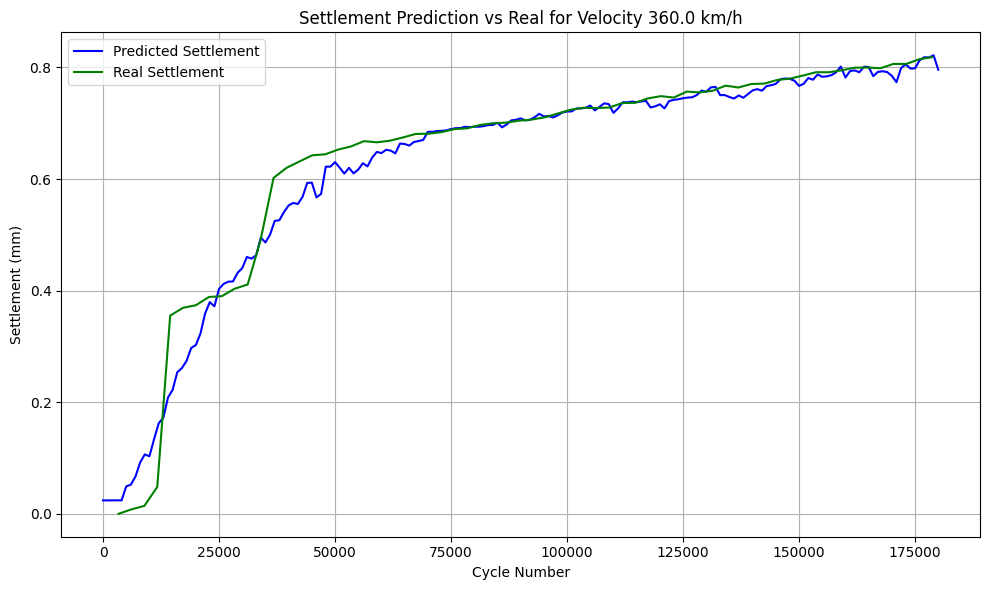

In [86]:
def generate_and_plot_settlement(model, ground_truth_df, start_cycle, end_cycle, step_size, velocity):
    """
    Generates and plots settlement predictions and ground truth values.

    Parameters:
        model: Trained machine learning model for prediction.
        ground_truth_df: DataFrame containing the ground truth data.
        start_cycle: Starting cycle number for prediction.
        end_cycle: Ending cycle number for prediction.
        step_size: Step size for generating cycles.
        velocity: Velocity at which predictions are generated.
    """
    # Generate cycle numbers for the prediction
    cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
    new_data = pd.DataFrame({
        'velocity': [velocity] * len(cycle_numbers),
        'Cycle_Number': cycle_numbers
    })

    # Predict settlement and convert to millimeters
    predicted_settlement = model.predict(new_data) * 1000

    # Filter ground truth data for the specified cycle range and velocity
    ground_truth_filtered = ground_truth_df[
        (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
        (ground_truth_df['velocity'] == velocity)
    ]

    # Convert real settlement (Difference) to millimeters
    ground_truth_filtered['Difference_mm'] = ground_truth_filtered['Difference'] * 1000
    
    # Plot predicted settlement
    plt.figure(figsize=(10, 6))
    plt.plot(cycle_numbers, predicted_settlement, label='Predicted Settlement', color='blue', marker='')
    
    # Plot real settlement (ground truth)
    plt.plot(ground_truth_filtered['Cycle_Number'], ground_truth_filtered['Difference_mm'], 
             label='Real Settlement', color='green', marker='')
    
    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Settlement (cm)')
    plt.title(f'Settlement Prediction vs Real for Velocity {velocity} km/h')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

generate_and_plot_settlement(ps_rf_model, averaged_df,
                             start_cycle=0, end_cycle=180000, step_size=1000,
                             velocity=360.0)

C:\Users\alira\AppData\Local\Temp\ipykernel_12956\1249910828.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['Difference_mm'] = ground_truth_filtered['Difference'] * 1000


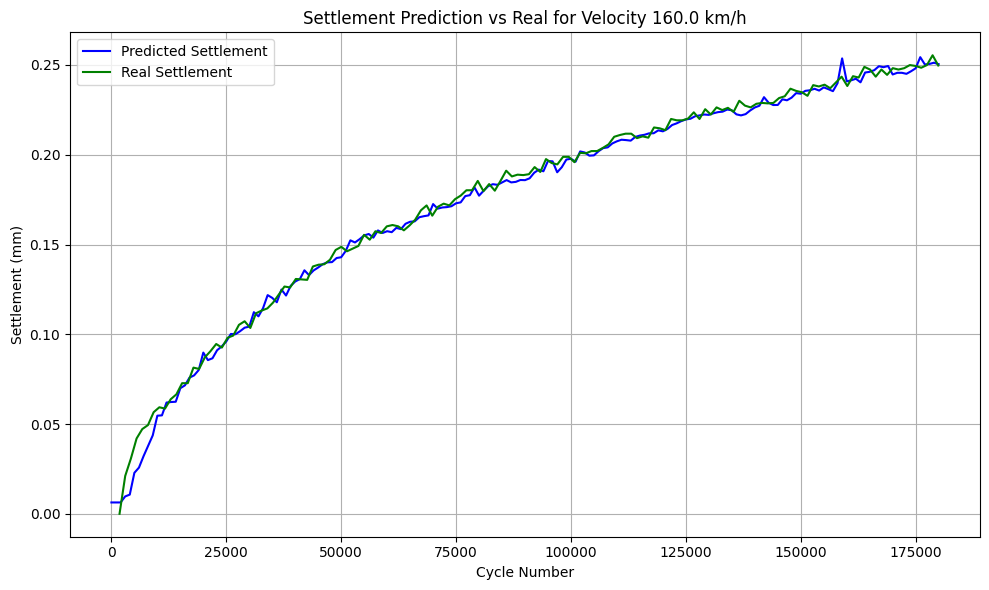

In [89]:
generate_and_plot_settlement(ps_rf_model, averaged_df,
                             start_cycle=0, end_cycle=180000, step_size=1000,
                             velocity=160.0)

In [88]:
averaged_df

,velocity,Cycle_Number,id,Period,2,4,5,6,7,9,...,134,135,136,137,138,139,experiment_number,smoothed_displacement,Difference,Smoothed_Difference
0,160.0,1772.25,80.5,300.65650,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003019,0.003032,0.003014,0.003013,0.003028,NaN,4.5,0.003017,0.000000,0.000000
1,160.0,3009.75,81.5,601.11325,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003019,0.003049,0.003029,0.003040,0.003046,NaN,4.5,0.003038,0.000021,0.000008
2,160.0,4246.75,82.5,901.65225,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003042,0.003052,0.003044,0.003057,0.003057,NaN,4.5,0.003048,0.000031,0.000016
3,160.0,5483.50,83.5,1202.14075,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003056,0.003055,0.003052,0.003057,0.003050,NaN,4.5,0.003059,0.000042,0.000024
4,160.0,6721.00,84.5,1502.75775,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003066,0.003071,0.003056,0.003074,0.003060,NaN,4.5,0.003065,0.000047,0.000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,380.0,188809.50,1157.0,19230.41400,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003555,0.003592,0.003562,0.003597,0.003587,NaN,6.5,0.003595,0.000194,0.000190
594,380.0,191746.00,1158.0,19530.91400,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003567,0.003580,0.003580,0.003590,0.003594,NaN,6.5,0.003592,0.000191,0.000193
595,380.0,194684.50,1159.0,19831.52350,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003577,0.003572,0.003592,0.003580,0.003607,NaN,6.5,0.003592,0.000191,0.000196
596,380.0,197626.00,1160.0,20132.34350,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003587,0.003575,0.003597,0.003590,0.003604,NaN,6.5,0.003602,0.000201,0.000199


C:\Users\alira\AppData\Local\Temp\ipykernel_12956\1965881191.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['Smoothed_Difference_mm'] = ground_truth_filtered['Smoothed_Difference'] * 1000
C:\Users\alira\AppData\Local\Temp\ipykernel_12956\1965881191.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['Smoothed_Difference_mm'] = ground_truth_filtered['Smoothed_Difference'] * 1000
C:\Users\alira\AppData\Local\Temp\ipykernel_12956\1965881191.py:51: SettingWithC

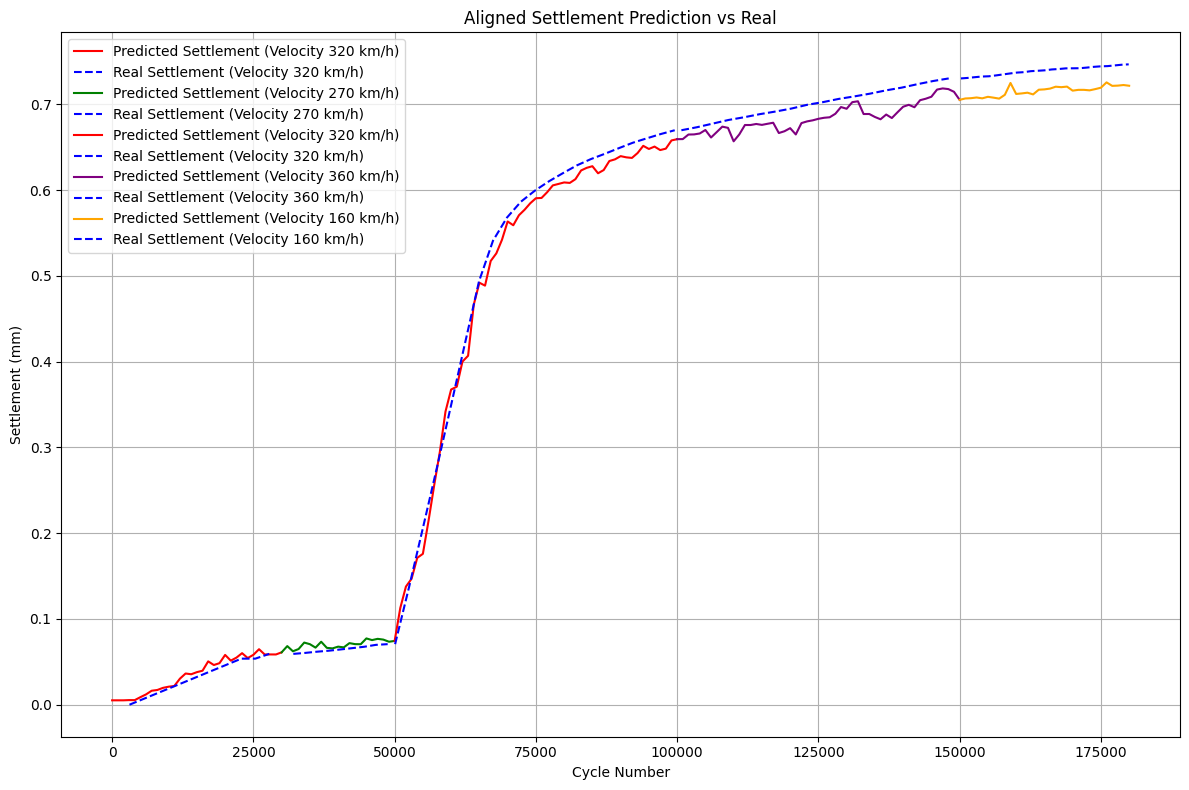

In [91]:
def generate_and_plot_settlement_multi_aligned(model, ground_truth_df, velocity_ranges, step_size):
    """
    Generates and plots settlement predictions for multiple velocity ranges, ensuring proper alignment.

    Parameters:
        model: Trained machine learning model for prediction.
        ground_truth_df: DataFrame containing the ground truth data.
        velocity_ranges: List of lists, where each sublist contains [velocity, start_cycle, end_cycle].
        step_size: Step size for generating cycles.
    """
    all_cycle_numbers = []
    all_predictions = []
    previous_end_value = None  # To align subsequent predictions
    previous_gt_end_value = None  # To align subsequent ground truth values

    plt.figure(figsize=(12, 8))

    # Define color map for the velocities
    color_map = {velocity: color for velocity, color in zip(
        sorted(set([v[0] for v in velocity_ranges])),
        ['orange', 'green', 'red', 'purple', 'cyan', 'magenta']
    )}

    for i, (velocity, start_cycle, end_cycle) in enumerate(velocity_ranges):
        # Filter and plot ground truth data for the current range
        ground_truth_filtered = ground_truth_df[
            (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
            (ground_truth_df['velocity'] == velocity)
        ]

        # Generate cycle numbers for the current velocity range
        cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
        new_data = pd.DataFrame({
            'velocity': [velocity] * len(cycle_numbers),
            'Cycle_Number': cycle_numbers
        })

        # Predict settlement for the current velocity and convert to millimeters
        predicted_settlement = model.predict(new_data) * 1000

        # Convert real settlement (Smoothed_Difference) to millimeters
        ground_truth_filtered['Smoothed_Difference_mm'] = ground_truth_filtered['Smoothed_Difference'] * 1000

        # Adjust predictions for continuity based on the previous end value
        if previous_end_value is not None:
            adjustment = previous_end_value - predicted_settlement[0]
            predicted_settlement += adjustment
        
        if previous_gt_end_value is not None:
            adjustment = previous_gt_end_value - ground_truth_filtered['Smoothed_Difference_mm'].iloc[0]
            ground_truth_filtered['Smoothed_Difference_mm'] += adjustment

        # Update the end value for the next velocity
        previous_end_value = predicted_settlement[-1]
        previous_gt_end_value = ground_truth_filtered['Smoothed_Difference_mm'].iloc[-1]

        # Append cycle numbers and predictions for the current range
        all_cycle_numbers.extend(cycle_numbers)
        all_predictions.extend(predicted_settlement)

        # Plot predictions
        plt.plot(cycle_numbers, predicted_settlement,
                 label=f'Predicted Settlement (Velocity {velocity} km/h)',
                 marker='',
                 color=color_map[velocity])

        # Plot real settlement (Smoothed_Difference_mm)
        plt.plot(ground_truth_filtered['Cycle_Number'], ground_truth_filtered['Smoothed_Difference_mm'], 
                 label=f'Real Settlement (Velocity {velocity} km/h)',
                 color='b', linestyle='dashed')

    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Settlement (cm)')
    plt.title('Aligned Settlement Prediction vs Real')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
velocity_ranges = [
    [320, 0, 30000],
    [270, 30000, 50000],
    [320, 50000, 100000],
    [360, 100000, 150000],
    [160, 150000, 180000]
]

generate_and_plot_settlement_multi_aligned(
    model=ps_rf_model,
    ground_truth_df=averaged_df,
    velocity_ranges=velocity_ranges,
    step_size=1000
)


In [6]:
average_df

,velocity,Cycle_Number,Period,experiment_number,position,displacement,smoothed_displacement
0,160.0,1772.25,300.65650,4.5,0.5,0.000200,0.000200
1,160.0,3009.75,601.11325,4.5,0.5,0.000201,0.000199
2,160.0,4246.75,901.65225,4.5,0.5,0.000195,0.000198
3,160.0,5483.50,1202.14075,4.5,0.5,0.000196,0.000197
4,160.0,6721.00,1502.75775,4.5,0.5,0.000197,0.000196
...,...,...,...,...,...,...,...
593,380.0,188809.50,19230.41400,6.5,0.5,0.000258,0.000261
594,380.0,191746.00,19530.91400,6.5,0.5,0.000264,0.000260
595,380.0,194684.50,19831.52350,6.5,0.5,0.000261,0.000260
596,380.0,197626.00,20132.34350,6.5,0.5,0.000256,0.000260


# Acceleration

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
import numpy as np
output_file_path = "../acceleration/dataset/combined_valeurs.txt"

combined_df = pd.read_csv(output_file_path, delimiter='\t', header=None, engine='python')

combined_df['positive_max'] = combined_df.loc[:, 19:138].apply(lambda x: x[x >= 0].max(), axis=1)
combined_df['negative_max'] = combined_df.loc[:, 19:138].apply(lambda x: x[x <= 0].min(), axis=1)
combined_df.rename(columns={0: "Date", 8: "velocity", 3: "Cycle_Number", 140: "experiment_number", 141: "position"}, inplace=True)

# Map 'position' column
combined_df['position'] = combined_df['position'].map({'Right': 0, 'Left': 1})
combined_df.drop(columns=['Date'], inplace=True)
experiment_numbers = [2, 3, 6, 7]

# Creating separate DataFrames for each experiment number
experiment_dfs = {num: combined_df[combined_df['experiment_number'] == num] for num in experiment_numbers}
table_2 = experiment_dfs[2].reset_index(drop=True)
table_3 = experiment_dfs[3].reset_index(drop=True)
table_6 = experiment_dfs[6].reset_index(drop=True)
table_7 = experiment_dfs[7].reset_index(drop=True)
table_2['id'] = range(len(table_2))
table_3['id'] = range(len(table_3))
table_6['id'] = range(len(table_6))
table_7['id'] = range(len(table_7))
tables = [table_2, table_3, table_6, table_7]
combined_df = pd.concat(tables)


# Compute mean for the group
final_df = combined_df.groupby(['id', 'velocity']).mean().reset_index()

# Rename 'velocity_group' back to 'velocity' for clarity
# final_df.rename(columns={'velocity_group': 'velocity'}, inplace=True)
final_df = final_df[final_df['velocity'] != 400.0]
final_df = final_df.groupby(['velocity', 'Cycle_Number'], as_index=False).mean()


def create_tables_by_velocity_position(df):
    tables = {}
    unique_velocities = df['velocity'].unique()

    print(unique_velocities)
    
    for velocity in unique_velocities:
        # Filter the DataFrame based on the current combination of velocity and position
        filtered_df = df[(df['velocity'] == int(velocity))]
        
        # Create a dynamic name for the DataFrame based on velocity and position
        table_name = f"df_{int(velocity)}"
        tables[table_name] = filtered_df
    
    return tables

tables_dict = create_tables_by_velocity_position(final_df)
print(tables_dict)
def calculate_smoothed_acceleration(df, window_size=5):
    df['smoothed_positive_max'] = df['positive_max'].rolling(window=window_size, center=True).mean()
    df['smoothed_negative_max'] = df['negative_max'].rolling(window=window_size, center=True).mean()

    # Set the first and last values as per previous conditions
    if len(df) > 1:
        first_value = df['positive_max'].iloc[0]
        connect_value = df['smoothed_positive_max'].iloc[window_size]
        linear_interp_start = np.linspace(first_value, connect_value, num=window_size)
        df['smoothed_positive_max'].iloc[:window_size] = linear_interp_start

        # Last section: Linearly connect from the smoothed value before window_size to the last value
        last_value = df['positive_max'].iloc[-1]
        connect_value_end = df['smoothed_positive_max'].iloc[-(window_size + 1)]
        linear_interp_end = np.linspace(connect_value_end, last_value, num=window_size)
        df['smoothed_positive_max'].iloc[-window_size:] = linear_interp_end

        first_value = df['negative_max'].iloc[0]
        connect_value = df['smoothed_negative_max'].iloc[window_size]
        linear_interp_start = np.linspace(first_value, connect_value, num=window_size)
        df['smoothed_negative_max'].iloc[:window_size] = linear_interp_start

        # Last section: Linearly connect from the smoothed value before window_size to the last value
        last_value = df['negative_max'].iloc[-1]
        connect_value_end = df['smoothed_negative_max'].iloc[-(window_size + 1)]
        linear_interp_end = np.linspace(connect_value_end, last_value, num=window_size)
        df['smoothed_negative_max'].iloc[-window_size:] = linear_interp_end
    return df

for table_name, table_df in tables_dict.items():
    tables_dict[table_name] = calculate_smoothed_acceleration(table_df, 5)

combined_df = pd.concat(tables_dict.values(), ignore_index=True)
combined_df



X = combined_df[['velocity', 'Cycle_Number']]
y = combined_df['smoothed_negative_max']

# Splitting data into train/validation/test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
# This results in 60% train, 20% validation, and 20% test splits

# Custom scoring function
def custom_scorer(y_true, y_pred):
    # Using the inverse of MAE as the scoring metric
    score = 1 - mean_absolute_error(y_true, y_pred)
    return score

# Define the model and hyperparameters to tune
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [150],
    'max_depth': [16, 18],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1],
    'max_features': ['auto', 'sqrt']
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=make_scorer(custom_scorer),
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
n_max_rf_model = grid_search.best_estimator_

# Cross-validate on the validation set with the selected best model for an unbiased evaluation
val_scores = cross_val_score(n_max_rf_model, X_val, y_val, cv=5, scoring=make_scorer(custom_scorer))
mean_val_score = np.mean(val_scores)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Validation Score (cross-validated): {mean_val_score:.4f}")

# Evaluate on the test set
n_max_rf_model.fit(X_train_val, y_train_val)  # Train on full train/validation data
y_test_pred = n_max_rf_model.predict(X_test)
test_score = custom_scorer(y_test, y_test_pred)

print(f"Test Score: {test_score:.4f}")


from sklearn.metrics import r2_score

y_pred_val = n_max_rf_model.predict(X_val)
r2_val = r2_score(y_val, y_pred_val)

y_pred_test = n_max_rf_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'R2 Score on Validation Set: {r2_val:.4f}')
print(f'R2 Score on Test Set: {r2_test:.4f}')



C:\Users\alira\AppData\Local\Temp\ipykernel_19020\1861225952.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df = final_df.groupby(['velocity', 'Cycle_Number'], as_index=False).mean()
C:\Users\alira\AppData\Local\Temp\ipykernel_19020\1861225952.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df = final_df.groupby(['velocity', 'Cycle_Number'], as_index=False).mean()
C:\Users\alira\AppData\Local\Temp\ipykernel_19020\1861225952.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[160. 210. 270. 320. 360. 380.]
{'df_160':      velocity  Cycle_Number     id            1    2    4    5    6    7  \
0       160.0       1772.25   80.5    300.65650  0.0  3.0  4.5  1.0  1.0   
1       160.0       3009.75   81.5    601.11325  0.0  3.0  4.5  1.0  1.0   
2       160.0       4246.75   82.5    901.65225  0.0  3.0  4.5  1.0  1.0   
3       160.0       5483.50   83.5   1202.14075  0.0  3.0  4.5  1.0  1.0   
4       160.0       6721.00   84.5   1502.75775  0.0  3.0  4.5  1.0  1.0   
..        ...           ...    ...          ...  ...  ...  ...  ...  ...   
156     160.0     194768.75  236.5  47182.42950  0.0  3.0  4.5  1.0  1.0   
157     160.0     196004.00  237.5  47482.93375  0.0  3.0  4.5  1.0  1.0   
158     160.0     197242.75  238.5  47783.59375  0.0  3.0  4.5  1.0  1.0   
159     160.0     198479.50  239.5  48084.02750  0.0  3.0  4.5  1.0  1.0   
160     160.0     199717.25  240.5  48384.71475  0.0  3.0  4.5  1.0  1.0   

            9  ...       134       135      

c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users

Best Model Parameters: {'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Validation Score (cross-validated): 0.3199
Test Score: 0.8132
R2 Score on Validation Set: 0.9994
R2 Score on Test Set: 0.9960


In [10]:
import pickle

# Save the model to a file
with open('../../app/models/v1/n_max_acc_rf_model.pkl', 'wb') as file:
    pickle.dump(n_max_rf_model, file)

print("Model saved successfully as n_max_acc_rf_model.pkl")

Model saved successfully as n_max_acc_rf_model.pkl


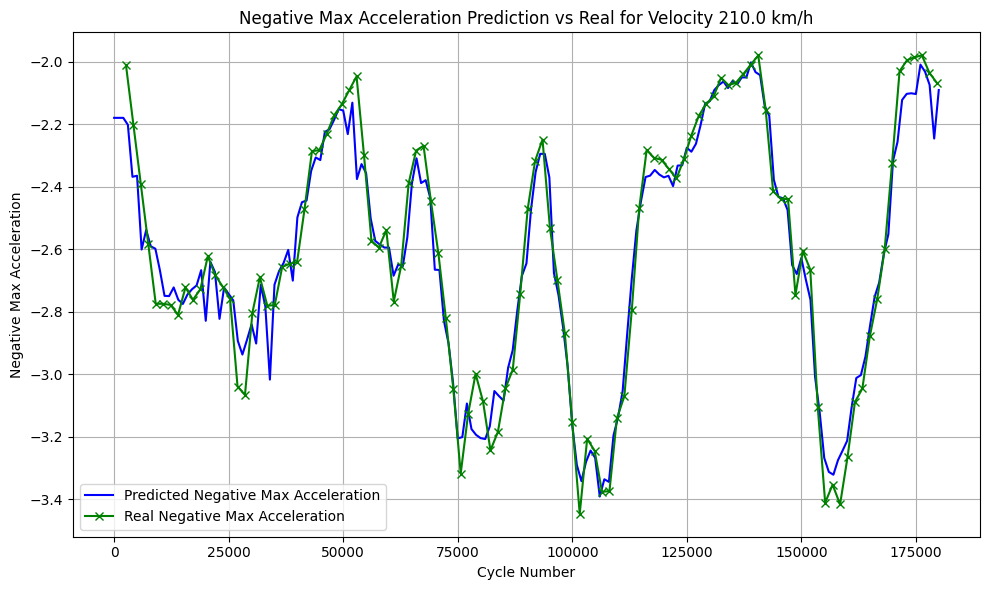

In [93]:
def generate_and_plot_neg_acceleration(model, ground_truth_df, start_cycle, end_cycle, step_size, velocity):
    """
    Generate and plot negative max acceleration predictions vs ground truth.

    Parameters:
        model: Trained machine learning model for prediction.
        ground_truth_df: DataFrame containing the ground truth data.
        start_cycle: Starting cycle number for prediction.
        end_cycle: Ending cycle number for prediction.
        step_size: Step size for generating cycles.
        velocity: Velocity at which predictions are generated.
    """
    # Generate cycle numbers for the prediction
    cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
    new_data = pd.DataFrame({
        'velocity': [velocity] * len(cycle_numbers),
        'Cycle_Number': cycle_numbers
    })

    # Predict negative max acceleration
    predicted_neg_acceleration = model.predict(new_data)

    # Filter ground truth data for the specified cycle range and velocity
    ground_truth_filtered = ground_truth_df[
        (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
        (ground_truth_df['velocity'] == velocity)
    ]
    
    # Plot predicted negative max acceleration
    plt.figure(figsize=(10, 6))
    plt.plot(cycle_numbers, predicted_neg_acceleration, label='Predicted Negative Max Acceleration', color='blue', marker='')
    
    # Plot real negative max acceleration (ground truth)
    plt.plot(ground_truth_filtered['Cycle_Number'], ground_truth_filtered['smoothed_negative_max'], 
             label='Real Negative Max Acceleration', color='green', marker='x')
    
    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Negative Max Acceleration')
    plt.title(f'Negative Max Acceleration Prediction vs Real for Velocity {velocity} km/h')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
generate_and_plot_neg_acceleration(
    model=n_max_rf_model,
    ground_truth_df=combined_df,
    start_cycle=0,
    end_cycle=180000,
    step_size=1000,
    velocity=210.0
)


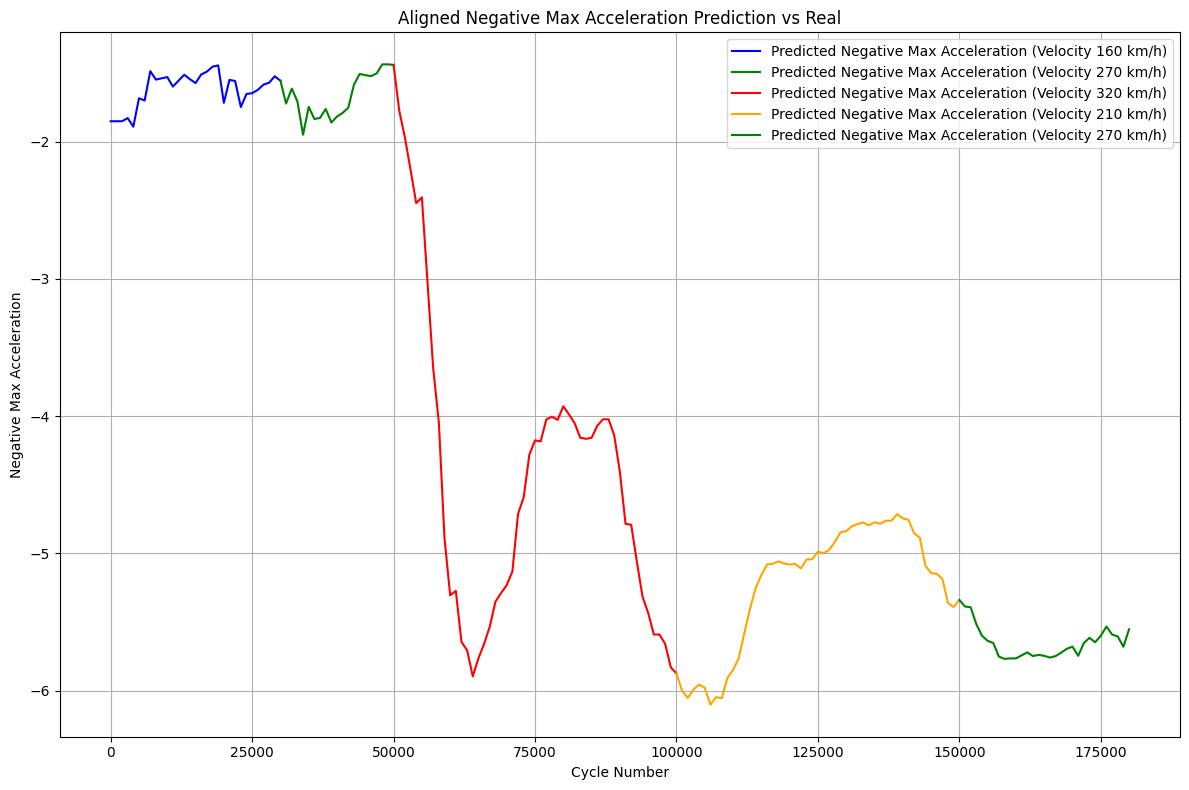

In [94]:
def generate_and_plot_neg_acceleration_multi_aligned(model, ground_truth_df, velocity_ranges, step_size):
    """
    Generates and plots negative max acceleration predictions for multiple velocity ranges, ensuring proper alignment.

    Parameters:
        model: Trained machine learning model for prediction.
        ground_truth_df: DataFrame containing the ground truth data.
        velocity_ranges: List of lists, where each sublist contains [velocity, start_cycle, end_cycle].
        step_size: Step size for generating cycles.
    """
    all_cycle_numbers = []
    all_predictions = []
    previous_end_value = None  # To align subsequent predictions

    # Define a color map for velocities
    color_map = {velocity: color for velocity, color in zip(
        sorted(set([v[0] for v in velocity_ranges])),
        ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta']
    )}

    plt.figure(figsize=(12, 8))

    for i, (velocity, start_cycle, end_cycle) in enumerate(velocity_ranges):
        # Generate cycle numbers for the current velocity range
        cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
        new_data = pd.DataFrame({
            'velocity': [velocity] * len(cycle_numbers),
            'Cycle_Number': cycle_numbers
        })

        # Predict negative max acceleration for the current velocity
        predicted_neg_acceleration = model.predict(new_data)

        # Adjust predictions for continuity based on the previous end value
        if previous_end_value is not None:
            adjustment = previous_end_value - predicted_neg_acceleration[0]
            predicted_neg_acceleration += adjustment

        # Update the end value for the next velocity
        previous_end_value = predicted_neg_acceleration[-1]

        # Append cycle numbers and predictions for the current range
        all_cycle_numbers.extend(cycle_numbers)
        all_predictions.extend(predicted_neg_acceleration)

        # Plot predictions with the color based on the velocity
        plt.plot(cycle_numbers, predicted_neg_acceleration, 
                 label=f'Predicted Negative Max Acceleration (Velocity {velocity} km/h)',
                 color=color_map[velocity], marker='')

        # Filter and plot ground truth data for the current range
        ground_truth_filtered = ground_truth_df[
            (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
            (ground_truth_df['velocity'] == velocity)
        ]
        # plt.plot(
        #     ground_truth_filtered['Cycle_Number'],
        #     ground_truth_filtered['smoothed_negative_max'], 
        #     label=f'Real Negative Max Acceleration (Velocity {velocity} km/h)',
        #     color=color_map[velocity], linestyle='dashed', marker='x'
        # )

    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Negative Max Acceleration')
    plt.title('Aligned Negative Max Acceleration Prediction vs Real')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
velocity_ranges = [
    [160, 0, 30000],
    [270, 30000, 50000],
    [320, 50000, 100000],
    [210, 100000, 150000],
    [270, 150000, 180000]
]

generate_and_plot_neg_acceleration_multi_aligned(
    model=n_max_rf_model,
    ground_truth_df=combined_df,
    velocity_ranges=velocity_ranges,
    step_size=1000
)



## Pos Acc


Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\alira\anaconda3\envs\FYP\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\User

Best Model Parameters: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Validation Score (cross-validated): 0.5710
Test Score: 0.9088
R2 Score on Validation Set: 0.9996
R2 Score on Test Set: 0.9976


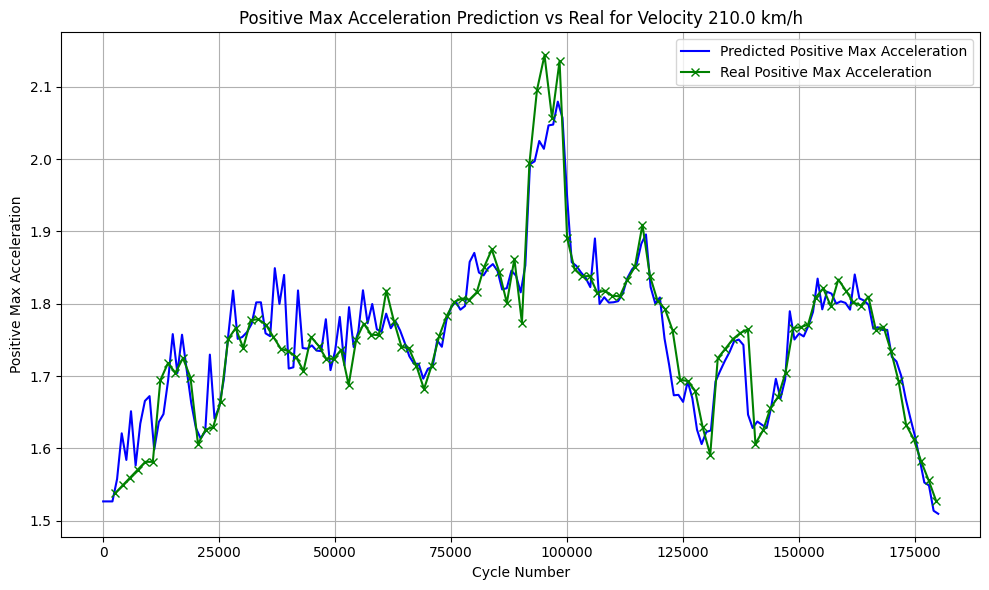

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
import numpy as np

def generate_and_plot_pos_acceleration(model, ground_truth_df, start_cycle, end_cycle, step_size, velocity):
    """
    Generate and plot postive max acceleration predictions vs ground truth.

    Parameters:
        model: Trained machine learning model for prediction.
        ground_truth_df: DataFrame containing the ground truth data.
        start_cycle: Starting cycle number for prediction.
        end_cycle: Ending cycle number for prediction.
        step_size: Step size for generating cycles.
        velocity: Velocity at which predictions are generated.
    """
    # Generate cycle numbers for the prediction
    cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
    new_data = pd.DataFrame({
        'velocity': [velocity] * len(cycle_numbers),
        'Cycle_Number': cycle_numbers
    })

    predicted_pos_acceleration = model.predict(new_data)

    # Filter ground truth data for the specified cycle range and velocity
    ground_truth_filtered = ground_truth_df[
        (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
        (ground_truth_df['velocity'] == velocity)
    ]
    
    plt.figure(figsize=(10, 6))
    plt.plot(cycle_numbers, predicted_pos_acceleration, label='Predicted Positive Max Acceleration', color='blue', marker='')
    
    plt.plot(ground_truth_filtered['Cycle_Number'], ground_truth_filtered['smoothed_positive_max'], 
             label='Real Positive Max Acceleration', color='green', marker='x')

    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Positive Max Acceleration')
    plt.title(f'Positive Max Acceleration Prediction vs Real for Velocity {velocity} km/h')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



X = combined_df[['velocity', 'Cycle_Number']]
y = combined_df['smoothed_positive_max']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


def custom_scorer(y_true, y_pred):
    score = 1 - mean_absolute_error(y_true, y_pred)
    return score

model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [150],
    'max_depth': [16, 18],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1],
    'max_features': ['auto', 'sqrt']
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=make_scorer(custom_scorer),
    n_jobs=-1,
    verbose=2
)

# Train the model with the best parameters using cross-validation on the train set
grid_search.fit(X_train, y_train)
p_max_rf_model = grid_search.best_estimator_

# Cross-validate on the validation set with the selected best model for an unbiased evaluation
val_scores = cross_val_score(p_max_rf_model, X_val, y_val, cv=5, scoring=make_scorer(custom_scorer))
mean_val_score = np.mean(val_scores)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Validation Score (cross-validated): {mean_val_score:.4f}")

# Evaluate on the test set
p_max_rf_model.fit(X_train_val, y_train_val)  # Train on full train/validation data
y_test_pred = p_max_rf_model.predict(X_test)
test_score = custom_scorer(y_test, y_test_pred)

print(f"Test Score: {test_score:.4f}")


from sklearn.metrics import r2_score

y_pred_val = p_max_rf_model.predict(X_val)
r2_val = r2_score(y_val, y_pred_val)

y_pred_test = p_max_rf_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'R2 Score on Validation Set: {r2_val:.4f}')
print(f'R2 Score on Test Set: {r2_test:.4f}')



# Example usage
generate_and_plot_pos_acceleration(
    model=p_max_rf_model,
    ground_truth_df=combined_df,
    start_cycle=0,
    end_cycle=180000,
    step_size=1000,
    velocity=210.0
)

In [12]:
import pickle

# Save the model to a file
with open('../../app/models/v1/p_max_acc_rf_model.pkl', 'wb') as file:
    pickle.dump(p_max_rf_model, file)

print("Model saved successfully as p_max_acc_rf_model.pkl")

Model saved successfully as p_max_acc_rf_model.pkl


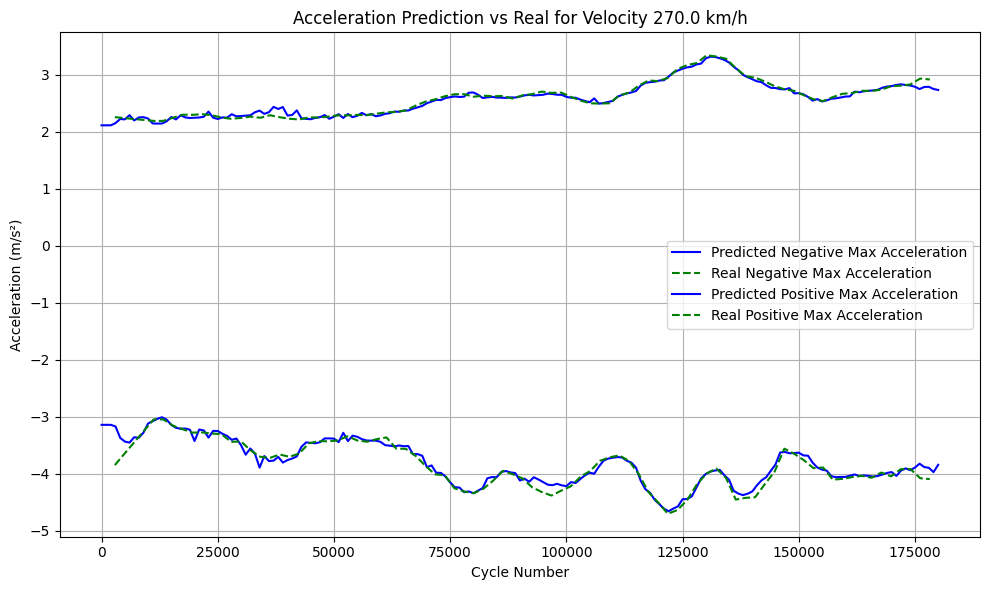

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

def generate_and_plot_accelerations(neg_model, pos_model, ground_truth_df, start_cycle, end_cycle, step_size, velocity):
    """
    Generate and plot both negative and positive max acceleration predictions vs ground truth.

    Parameters:
        neg_model: Trained machine learning model for predicting negative max acceleration.
        pos_model: Trained machine learning model for predicting positive max acceleration.
        ground_truth_df: DataFrame containing the ground truth data.
        start_cycle: Starting cycle number for prediction.
        end_cycle: Ending cycle number for prediction.
        step_size: Step size for generating cycles.
        velocity: Velocity at which predictions are generated.
    """
    # Generate cycle numbers for the prediction
    cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
    new_data = pd.DataFrame({
        'velocity': [velocity] * len(cycle_numbers),
        'Cycle_Number': cycle_numbers
    })

    # Predict negative and positive max acceleration
    predicted_neg_acceleration = neg_model.predict(new_data)  # Already in m/s²
    predicted_pos_acceleration = pos_model.predict(new_data)  # Already in m/s²

    # Filter ground truth data for the specified cycle range and velocity
    ground_truth_filtered = ground_truth_df[
        (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) & 
        (ground_truth_df['velocity'] == velocity)
    ]

    # Plot predicted and real accelerations
    plt.figure(figsize=(10, 6))

    # Plot predicted negative max acceleration
    plt.plot(cycle_numbers, predicted_neg_acceleration, label='Predicted Negative Max Acceleration', color='blue', marker='')

    # Plot real negative max acceleration
    if not ground_truth_filtered.empty:
        plt.plot(
            ground_truth_filtered['Cycle_Number'], 
            ground_truth_filtered['smoothed_negative_max'], 
            label='Real Negative Max Acceleration', 
            color='green', linestyle='dashed'
        )

    # Plot predicted positive max acceleration
    plt.plot(cycle_numbers, predicted_pos_acceleration, label='Predicted Positive Max Acceleration', color='blue', marker='')

    # Plot real positive max acceleration
    if not ground_truth_filtered.empty:
        plt.plot(
            ground_truth_filtered['Cycle_Number'], 
            ground_truth_filtered['smoothed_positive_max'], 
            label='Real Positive Max Acceleration', 
            color='green', linestyle='dashed'
        )

    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'Acceleration Prediction vs Real for Velocity {velocity} km/h')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
generate_and_plot_accelerations(
    neg_model=n_max_rf_model,
    pos_model=p_max_rf_model,
    ground_truth_df=combined_df,
    start_cycle=0,
    end_cycle=180000,
    step_size=1000,
    velocity=270.0
)


C:\Users\alira\AppData\Local\Temp\ipykernel_12956\200009233.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['smoothed_negative_max'] += adjustment
C:\Users\alira\AppData\Local\Temp\ipykernel_12956\200009233.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_filtered['smoothed_positive_max'] += adjustment
C:\Users\alira\AppData\Local\Temp\ipykernel_12956\200009233.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

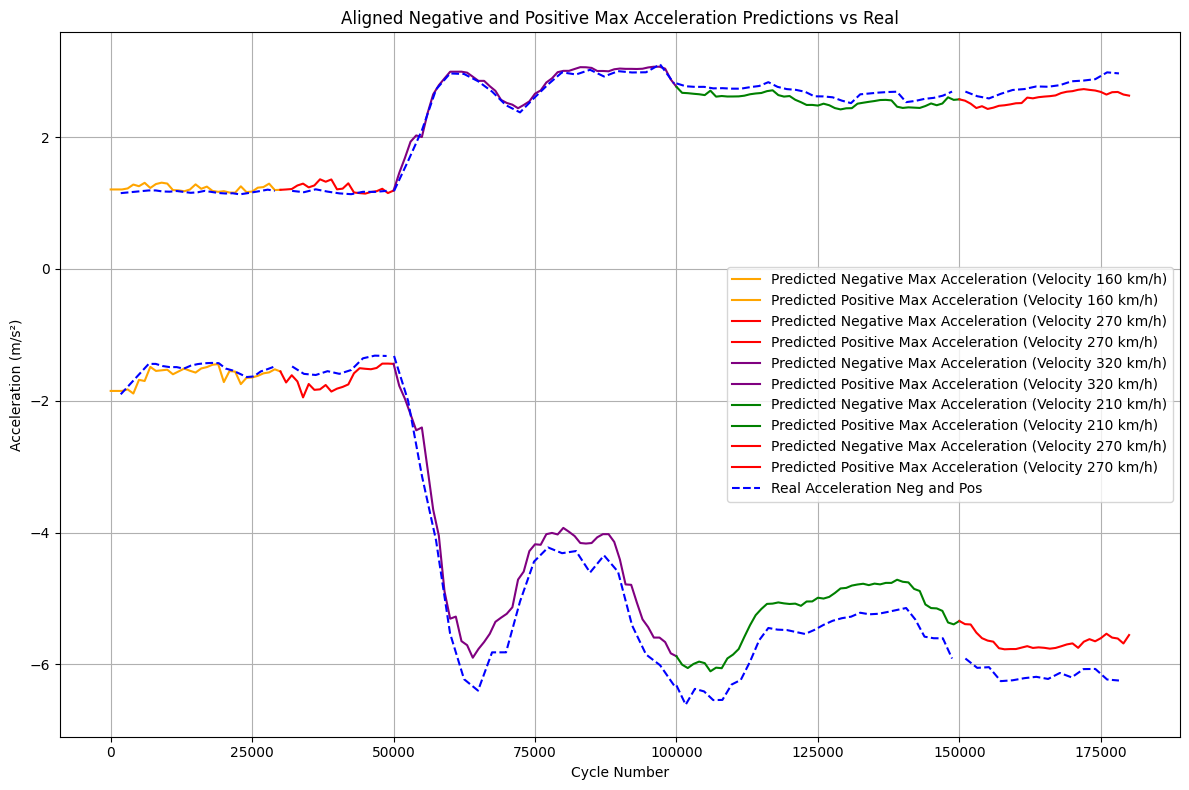

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

def generate_and_plot_accelerations_multi_aligned(neg_model, pos_model, ground_truth_df, velocity_ranges, step_size):
    """
    Generates and plots both negative and positive max acceleration predictions for multiple velocity ranges, ensuring proper alignment.

    Parameters:
        neg_model: Trained machine learning model for predicting negative max acceleration.
        pos_model: Trained machine learning model for predicting positive max acceleration.
        ground_truth_df: DataFrame containing the ground truth data.
        velocity_ranges: List of lists, where each sublist contains [velocity, start_cycle, end_cycle].
        step_size: Step size for generating cycles.
    """
    previous_neg_end_value = None  # To align subsequent negative predictions
    previous_pos_end_value = None  # To align subsequent positive predictions
    previous_gt_neg_end_value = None  # To align subsequent negative ground truth values
    previous_gt_pos_end_value = None  # To align subsequent positive ground truth values

    # Define a color map for velocities
    color_map = {velocity: color for velocity, color in zip(
        sorted(set([v[0] for v in velocity_ranges])),
        [ 'orange', 'green', 'red', 'purple', 'cyan', 'magenta']
    )}

    plt.figure(figsize=(12, 8))

    for i, (velocity, start_cycle, end_cycle) in enumerate(velocity_ranges):
        # Filter ground truth data for the current range
        ground_truth_filtered = ground_truth_df[
            (ground_truth_df['Cycle_Number'].between(start_cycle, end_cycle)) &
            (ground_truth_df['velocity'] == velocity)
        ]

        cycle_numbers = list(range(start_cycle, end_cycle + 1, step_size))
        new_data = pd.DataFrame({
            'velocity': [velocity] * len(cycle_numbers),
            'Cycle_Number': cycle_numbers
        })

        # Predict negative and positive max accelerations
        predicted_neg_acceleration = neg_model.predict(new_data)
        predicted_pos_acceleration = pos_model.predict(new_data)

        # Adjust negative predictions for continuity
        if previous_neg_end_value is not None:
            adjustment = previous_neg_end_value - predicted_neg_acceleration[0]
            predicted_neg_acceleration += adjustment

        # Adjust positive predictions for continuity
        if previous_pos_end_value is not None:
            adjustment = previous_pos_end_value - predicted_pos_acceleration[0]
            predicted_pos_acceleration += adjustment

        # Adjust negative ground truth for continuity
        if previous_gt_neg_end_value is not None:
            adjustment = previous_gt_neg_end_value - ground_truth_filtered['smoothed_negative_max'].iloc[0]
            ground_truth_filtered['smoothed_negative_max'] += adjustment

        # Adjust positive ground truth for continuity
        if previous_gt_pos_end_value is not None:
            adjustment = previous_gt_pos_end_value - ground_truth_filtered['smoothed_positive_max'].iloc[0]
            ground_truth_filtered['smoothed_positive_max'] += adjustment

        # Update the end values for the next velocity
        previous_neg_end_value = predicted_neg_acceleration[-1]
        previous_pos_end_value = predicted_pos_acceleration[-1]
        previous_gt_neg_end_value = ground_truth_filtered['smoothed_negative_max'].iloc[-1]
        previous_gt_pos_end_value = ground_truth_filtered['smoothed_positive_max'].iloc[-1]

        # Plot negative predictions
        plt.plot(cycle_numbers, predicted_neg_acceleration, 
                 label=f'Predicted Negative Max Acceleration (Velocity {velocity} km/h)',
                 color=color_map[velocity], linestyle='-')

        # Plot positive predictions
        plt.plot(cycle_numbers, predicted_pos_acceleration, 
                 label=f'Predicted Positive Max Acceleration (Velocity {velocity} km/h)',
                 color=color_map[velocity], linestyle='-')

        # Plot ground truth data (Real acceleration neg and pos) in a unified title and color
        plt.plot(
            ground_truth_filtered['Cycle_Number'],
            ground_truth_filtered['smoothed_negative_max'], 
            color='blue', linestyle='dashed'
        )

        plt.plot(
            ground_truth_filtered['Cycle_Number'],
            ground_truth_filtered['smoothed_positive_max'], 
            color='blue', linestyle='dashed'
        )

    # Consolidated legend for real values
    plt.plot([], [], color='blue', linestyle='dashed', label='Real Acceleration Neg and Pos')

    # Plot settings
    plt.xlabel('Cycle Number')
    plt.ylabel('Acceleration (m/s²)')
    plt.title('Aligned Negative and Positive Max Acceleration Predictions vs Real')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
velocity_ranges = [
    [160, 0, 30000],
    [270, 30000, 50000],
    [320, 50000, 100000],
    [210, 100000, 150000],
    [270, 150000, 180000]
]

generate_and_plot_accelerations_multi_aligned(
    neg_model=n_max_rf_model,
    pos_model=p_max_rf_model,
    ground_truth_df=combined_df,
    velocity_ranges=velocity_ranges,
    step_size=1000
)


In [13]:
averaged_df

,velocity,Cycle_Number,id,Period,2,4,5,6,7,9,...,134,135,136,137,138,139,experiment_number,smoothed_displacement,Difference,Smoothed_Difference
0,160.0,1772.25,80.5,300.65650,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003019,0.003032,0.003014,0.003013,0.003028,NaN,4.5,0.003017,0.000000,0.000000
1,160.0,3009.75,81.5,601.11325,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003019,0.003049,0.003029,0.003040,0.003046,NaN,4.5,0.003038,0.000021,0.000008
2,160.0,4246.75,82.5,901.65225,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003042,0.003052,0.003044,0.003057,0.003057,NaN,4.5,0.003048,0.000031,0.000016
3,160.0,5483.50,83.5,1202.14075,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003056,0.003055,0.003052,0.003057,0.003050,NaN,4.5,0.003059,0.000042,0.000024
4,160.0,6721.00,84.5,1502.75775,0.0,1.0,14.5,1.0,1.0,4.116579,...,0.003066,0.003071,0.003056,0.003074,0.003060,NaN,4.5,0.003065,0.000047,0.000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,380.0,188809.50,1157.0,19230.41400,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003555,0.003592,0.003562,0.003597,0.003587,NaN,6.5,0.003595,0.000194,0.000190
594,380.0,191746.00,1158.0,19530.91400,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003567,0.003580,0.003580,0.003590,0.003594,NaN,6.5,0.003592,0.000191,0.000193
595,380.0,194684.50,1159.0,19831.52350,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003577,0.003572,0.003592,0.003580,0.003607,NaN,6.5,0.003592,0.000191,0.000196
596,380.0,197626.00,1160.0,20132.34350,0.0,1.0,14.5,1.0,1.0,9.776876,...,0.003587,0.003575,0.003597,0.003590,0.003604,NaN,6.5,0.003602,0.000201,0.000199
